## Dimensions
1. Number of clusters (3,5,7,9)
2. Cluster validity index (DBIndex, Silhoutte Index, Dunn Index)
3. Algorithms (Genetic, Particle Swarm, Particle Gray Wolf)
4. Datasets (BBC, BBC Sports, Reuters, 20 newsgroup, etc.)

In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Time to pre-process : 12.640625
Number of documents: 4069


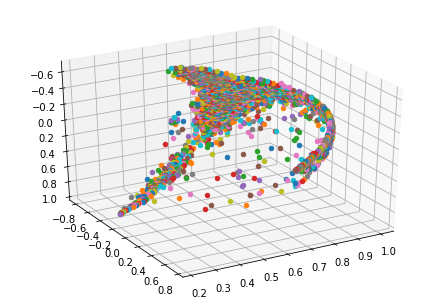

In [2]:
all_texts=[]
Y = []
dictionary= {}
start = time.process_time()
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//Reviews")
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GA")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process : "+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
ax = Axes3D(fig)
print("Number of documents: "+str(len(X)))
for j in range(len(X)):
    temp = ' '.join(map(str, X[j]))
    dictionary[temp]=Y[j]
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 120)

In [3]:
K=7
P=30
cross_over_rate=0.1
mutation_rate=0.01
number_of_generations=100

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [8]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [9]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [10]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            left_parent_1 = parent1[:i]
            right_parent_1= parent1[i:]
            left_parent_2 = parent2[:i]
            right_parent_2= parent2[i:]
            child1 = left_parent_1
            child2 = left_parent_2
            child1.extend(right_parent_2)
            child2.extend(right_parent_1)
            _,fitness_values = fitness_evaluation([child1,child2])
            temp[fitness_values[0]]=child1
            temp[fitness_values[1]]=child2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [11]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [12]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

Cluster purity measure indexes

In [13]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def calinski_harabasz(chromsome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [17]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [18]:
def supervised_scores(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    
    Y_actual=[]
    Y_pred=[]
    for i in range(K):
        t=[]
        for j in range(len(clusters[i])):
            temp = ' '.join(map(str, clusters[i][j]))
            Y_actual.append(dictionary[temp])
            t.append(dictionary[temp])
        print(t)
        pred = statistics.mode(t)
        print(pred)
        for j in range(len(clusters[i])):
            Y_pred.append(pred)
            
    print(confusion_matrix(Y_actual, Y_pred))
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [19]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    start = time.process_time()
    population = population_initialization()
    gen=0
    return_chromosome=[]
    gen_fitness = []
    for i in range(number_of_generations):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
        temp = []
        temp.append(str(gen))
        temp.append(str(max(fitness)))
        gen_fitness.append(temp)
        print("Generation: "+str(gen)+" | Best fitness: "+str(max(fitness)))
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GA with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return population[fitness.index(max(fitness))]

In [20]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#99ddff','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation: 1 | Best fitness: 8.252823529201457
Generation: 2 | Best fitness: 8.252823529201441
Generation: 3 | Best fitness: 8.50244989159766
Generation: 4 | Best fitness: 8.502449891597658
Generation: 5 | Best fitness: 7.649588329258814
Generation: 6 | Best fitness: 8.686385625120707
Generation: 7 | Best fitness: 8.68638562512071
Generation: 8 | Best fitness: 8.116898731481342
Generation: 9 | Best fitness: 7.052910097625225
Generation: 10 | Best fitness: 6.732603483805195
Generation: 11 | Best fitness: 6.806063434007725
Generation: 12 | Best fitness: 8.017765252965916
Generation: 13 | Best fitness: 8.017765252965907
Generation: 14 | Best fitness: 5.5889316853895625
Generation: 15 | Best fitness: 6.9300325242674905
Generation: 16 | Best fitness: 6.886372917290073
Generation: 17 | Best fitness: 7.6254101960191445
Generation: 18 | Best fitness: 7.163707430405111
Generation: 19 | Best fitness: 6.846944524005333
Generation: 20 | Best fitness: 7.20695708722368
Generation: 21 | Best fitness

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 77 | Best fitness: 8.964182851652023
Generation: 78 | Best fitness: 6.5492892689633635
Generation: 79 | Best fitness: 6.702347906842933
Generation: 80 | Best fitness: 9.16048118389585
Generation: 81 | Best fitness: 9.160481183895815
Generation: 82 | Best fitness: 6.701519769860734
Generation: 83 | Best fitness: 9.875255091488812
Generation: 84 | Best fitness: 7.193058910641478
Generation: 85 | Best fitness: 7.232071705823338
Generation: 86 | Best fitness: 10.286867668582905
Generation: 87 | Best fitness: 10.23018260572938
Generation: 88 | Best fitness: 7.409879049872696
Generation: 89 | Best fitness: 8.590679015906145
Generation: 90 | Best fitness: 6.555573321123601


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 91 | Best fitness: 6.164631359773228
Generation: 92 | Best fitness: 6.164631359773202
Generation: 93 | Best fitness: 7.390263594644944
Generation: 94 | Best fitness: 6.678196227097862
Generation: 95 | Best fitness: 10.396899267740844
Generation: 96 | Best fitness: 9.032389164319069
Generation: 97 | Best fitness: 6.395769965028709
Generation: 98 | Best fitness: 7.598278586523202
Generation: 99 | Best fitness: 9.578526636519776
Generation: 100 | Best fitness: 6.722159131118852
Time taken: 2792.375
DB Index        :1.18717782958262
Silhoutte Index :0.6019606457431107
Calinski-Harabasz Index :12124.287521429764
2551
310
1208


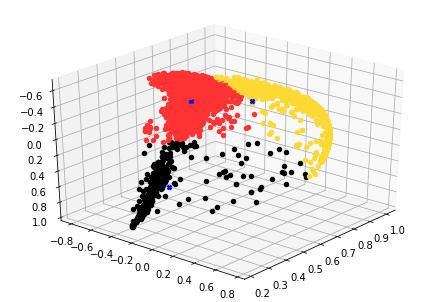

In [22]:
K = 3
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 26.47573834377188
Generation: 2 | Best fitness: 26.475738343771898
Generation: 3 | Best fitness: 20.22552884614439
Generation: 4 | Best fitness: 15.690626409515605
Generation: 5 | Best fitness: 21.077466343167863
Generation: 6 | Best fitness: 25.972527561993175
Generation: 7 | Best fitness: 20.274213957042466
Generation: 8 | Best fitness: 20.27421395704234
Generation: 9 | Best fitness: 25.21566743361565
Generation: 10 | Best fitness: 15.422283800083171
Generation: 11 | Best fitness: 16.927955622199853
Generation: 12 | Best fitness: 24.046672453804312
Generation: 13 | Best fitness: 17.30207520007987
Generation: 14 | Best fitness: 21.140271234848
Generation: 15 | Best fitness: 23.211726570449496
Generation: 16 | Best fitness: 22.117481477335915
Generation: 17 | Best fitness: 22.117481477336
Generation: 18 | Best fitness: 16.04401297644274
Generation: 19 | Best fitness: 15.909669072117689
Generation: 20 | Best fitness: 20.89400641433683
Generation: 21 | Best 

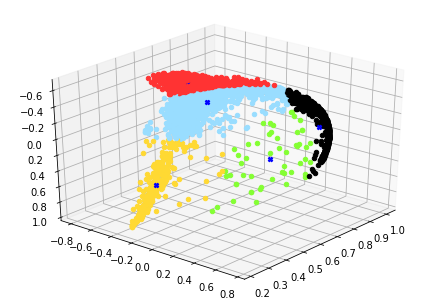

In [26]:
K = 5
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 27.652151234881067
Generation: 2 | Best fitness: 27.65215123488109
Generation: 3 | Best fitness: 36.72058233477152
Generation: 4 | Best fitness: 29.26693554953592
Generation: 5 | Best fitness: 33.59333875867256
Generation: 6 | Best fitness: 29.92013573201263
Generation: 7 | Best fitness: 29.920135732012522
Generation: 8 | Best fitness: 30.07437876406634
Generation: 9 | Best fitness: 30.07437876406682
Generation: 10 | Best fitness: 37.99444020667951
Generation: 11 | Best fitness: 35.818531261114195
Generation: 12 | Best fitness: 35.19778984325124
Generation: 13 | Best fitness: 28.894602083622875
Generation: 14 | Best fitness: 27.941063527323777
Generation: 15 | Best fitness: 27.020460827935228
Generation: 16 | Best fitness: 28.89105684738506
Generation: 17 | Best fitness: 27.391843572642614
Generation: 18 | Best fitness: 32.54805464288909
Generation: 19 | Best fitness: 32.54805464288944
Generation: 20 | Best fitness: 28.02312277203519
Generation: 21 | Best 

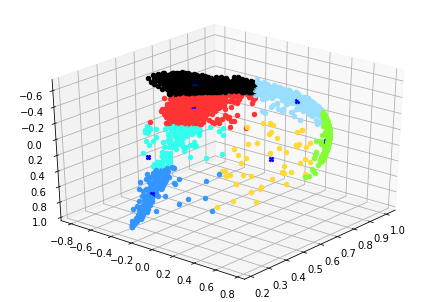

In [27]:
K = 7
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 43.722021273398944
Generation: 2 | Best fitness: 45.35480125069342
Generation: 3 | Best fitness: 41.21218009704734
Generation: 4 | Best fitness: 45.58293966521603
Generation: 5 | Best fitness: 45.58293966521638


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 6 | Best fitness: 50.88379198435756
Generation: 7 | Best fitness: 42.930043389918666
Generation: 8 | Best fitness: 49.20885849862726
Generation: 9 | Best fitness: 47.724243292216116
Generation: 10 | Best fitness: 53.3151923518178
Generation: 11 | Best fitness: 53.31519235181795
Generation: 12 | Best fitness: 63.3226478951417
Generation: 13 | Best fitness: 48.26922477476999
Generation: 14 | Best fitness: 53.640189400914466
Generation: 15 | Best fitness: 53.640189400914466
Generation: 16 | Best fitness: 53.59696630705514
Generation: 17 | Best fitness: 46.74682923467098
Generation: 18 | Best fitness: 48.14874270724912
Generation: 19 | Best fitness: 48.148742707248275
Generation: 20 | Best fitness: 45.566383960060605
Generation: 21 | Best fitness: 45.56638396006045
Generation: 22 | Best fitness: 51.29801900563724


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 23 | Best fitness: 51.873884446436676
Generation: 24 | Best fitness: 54.67784161751743
Generation: 25 | Best fitness: 49.687739099003096
Generation: 26 | Best fitness: 46.27843966271398
Generation: 27 | Best fitness: 46.24570873485277
Generation: 28 | Best fitness: 42.311263934025014
Generation: 29 | Best fitness: 48.9767780918854
Generation: 30 | Best fitness: 44.58335258270714
Generation: 31 | Best fitness: 46.21151938229729
Generation: 32 | Best fitness: 46.21151938229729
Generation: 33 | Best fitness: 43.47749215895148
Generation: 34 | Best fitness: 43.94114137563095
Generation: 35 | Best fitness: 43.941141375631126
Generation: 36 | Best fitness: 42.980356766721506
Generation: 37 | Best fitness: 43.00356036002919
Generation: 38 | Best fitness: 41.4392049017388
Generation: 39 | Best fitness: 42.7282111129116
Generation: 40 | Best fitness: 42.728211112911886
Generation: 41 | Best fitness: 37.05198470952135
Generation: 42 | Best fitness: 40.516338036689774
Generation: 43 |

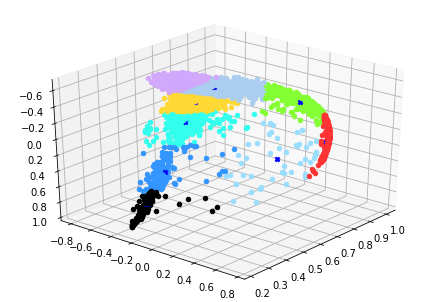

In [28]:
K = 9
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)